# PESTPP-GLM Part 2

In this notebook, we will actually run PESTPP-GLM in standard parameter estimation mode and regularization mode.  In both cases, we will use the baked-in bayes-linear posterior monte carlo analysis to get posterior forecast PDFs.  We will use the prior monte carlo outputs as the prior forecast PDF. We will reuse the jacobian we used for FOSM to save runs

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import flopy
import pyemu


flopy is installed in /Users/jwhite/Dev/gw1876/activities_stpete/notebooks/flopy


## SUPER IMPORTANT: SET HOW MANY PARALLEL WORKERS TO USE

In [2]:
num_workers = 20

In [3]:
t_d = "template_history"
m_d = "master_glm_run"

Load the control file:

In [4]:
pst = pyemu.Pst(os.path.join("master_glm","freyberg_pp.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_prsity6,cn_prsity6,log,1,0,0.176091,-0.30103,0.11928
cn_prsity7,cn_prsity7,log,1,0,0.176091,-0.30103,0.11928
...,...,...,...,...,...,...,...
pp_vka0,pp_vka0,fixed,32,1,10,0.1,2.475
pp_vka1,pp_vka1,log,32,0,1,-1,0.5
pp_vka2,pp_vka2,fixed,32,1,10,0.1,2.475
welflux,welflux,log,25,0,1,-1,0.5


Load and extract the portion of the geostatistical prior parameter covariance matrix we need for the integrated FOSM analyses build in to PESTPP-GLM

In [5]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))
cov.get(pst.adj_par_names).to_ascii(os.path.join(t_d,"glm_prior.cov"))

 set some control options specific to PESTPP-GLM.  Each of these has a solid internal default but we have found these setting work well for this synthetic problem.

In [6]:
pst.parameter_groups.loc[:,"forcen"] = "always_2"

In [7]:
pst.control_data.noptmax = 4
print(pst.pestpp_options)
pst.pestpp_options = {"forecasts":pst.pestpp_options["forecasts"]}
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 5
pst.pestpp_options["glm_num_reals"] = 100
pst.pestpp_options["parcov"] = "glm_prior.cov"
pst.pestpp_options["base_jacobian"] = "freyberg_reuse.jcb"
pst.pestpp_options["glm_normal_form"] = "diag"
pst.pestpp_options["max_n_super"] = 15
pst.pestpp_options["overdue_giveup_fac"] = 1.5
pst.pestpp_options["max_run_fail"] = 1
pst.svd_data.maxsing = 15
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

{'forecasts': 'fa_hw_20170701,fa_tw_20170701,hds_00_013_002_018,part_time,part_status'}
noptmax:4, npar_adj:529, nnz_obs:350


Copy the existing jacobian over

In [8]:
shutil.copy2(os.path.join("master_glm","freyberg_pp.jcb"),
             os.path.join(t_d,"freyberg_reuse.jcb"))

'template_history/freyberg_reuse.jcb'

Run in parallel locally...

In [9]:
pyemu.os_utils.start_workers(t_d,"pestpp-glm","freyberg_pp.pst",num_workers=num_workers,worker_root=".",
                           master_dir=m_d)

### post process

Now lets visualize what just happened:

In [10]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

/Users/jwhite/Dev/gw1876/activities_stpete/notebooks/pyemu/en.py:365: UserWarning: Ensemble.from_dataframe() is deprecated and has been replaced with the standard constructor, which takesthe same arguments
  warnings.warn("Ensemble.from_dataframe() is deprecated and has been "


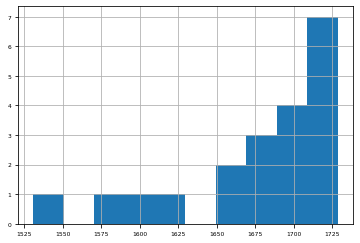

In [11]:
#ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20].hist()

Here we see the distribution of phi values across the 100 posterior realizations.  Should we accept all of these???  The theoretical phi for each realization that we should accept is number of nonzero obs, but because of model error, we rarely reach that on the first go (this is a determistic symptom what we will look at in depth later in the PESTPP-IES notebook in the context of total error covariance). But, for the time being, to get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [12]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] #just take the 20 lowest phi realizations

We can also load and plot the FOSM forecast results along side of the ensemble results - this let's us investigate the validity of the assumed linear relation between parameters and forecasts (the forecast sensitivity vectors):

In [13]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_20170701,-1161.4000,345.69900,-1852.7900,-469.9970,-44.2027,98.313900,-240.8300,152.4250
fa_tw_20170701,-633.3330,390.40400,-1414.1400,147.4750,881.7960,78.770100,724.2560,1039.3400
hds_00_013_002_018,39.7112,3.20426,33.3027,46.1197,36.8615,0.225489,36.4105,37.3125
part_status,2.0000,0.00000,2.0000,2.0000,2.0000,0.000000,2.0000,2.0000
part_time,463.7340,191.94600,79.8411,847.6270,148.8080,140.142000,-131.4760,429.0920


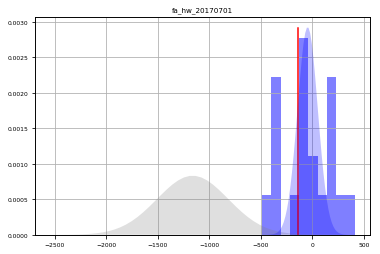

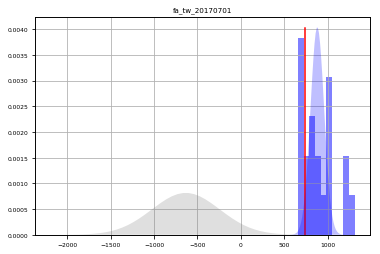

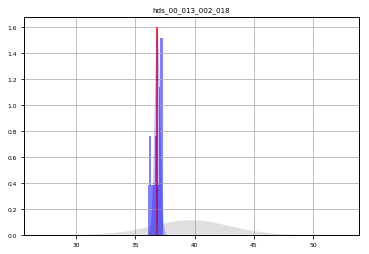

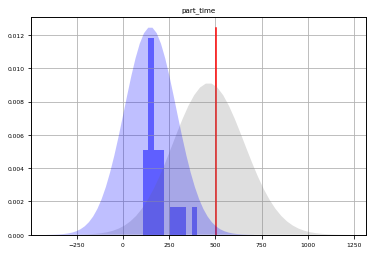

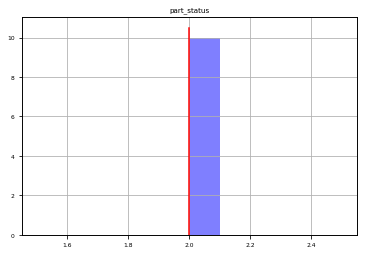

In [14]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,density=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()

Ok, so we see that the assumed linear parameter-forecast relation in the FOSM calculations seems to hold up - yeah!  But, neither the FOSM posterior nor the Monte Carlo posterior cover the truth for several foreacsts.  #sad.  Why is that?  Is it because we are using an imperfect model (yes), because we are using less parameters than we initially acknowledged (maybe).  We will return to this issue in the PESTPP-IES notebooks.

Let's now investigate the observations vs cooresponding simulated outputs:

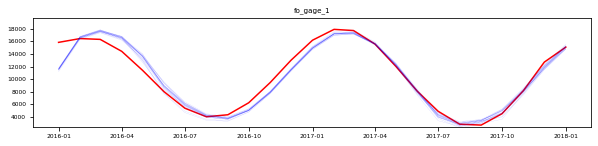

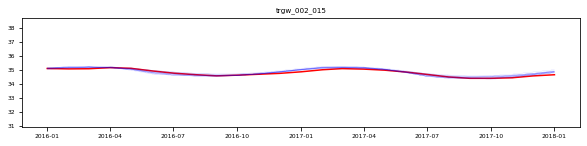

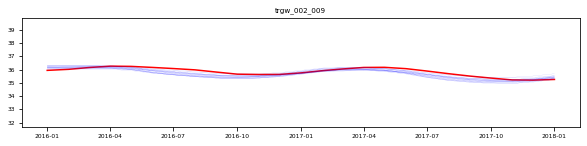

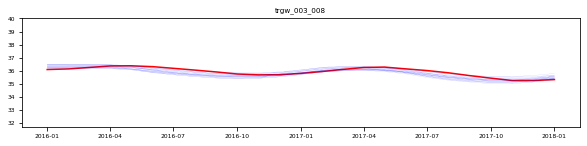

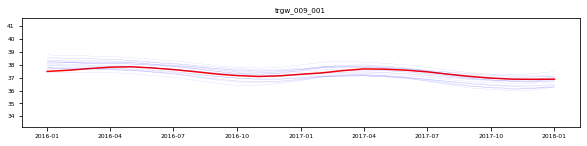

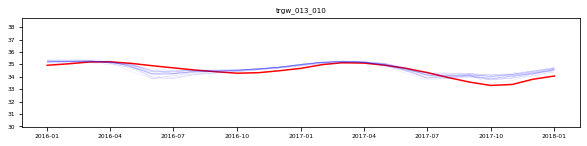

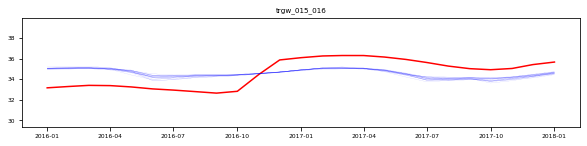

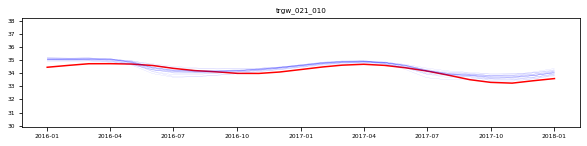

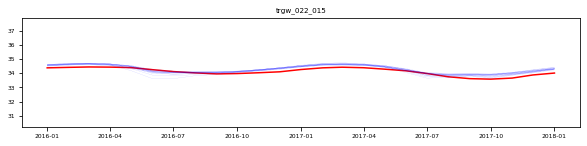

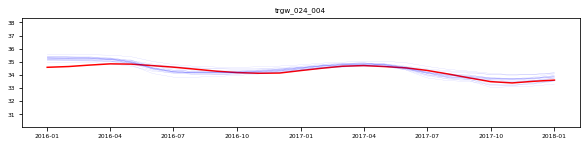

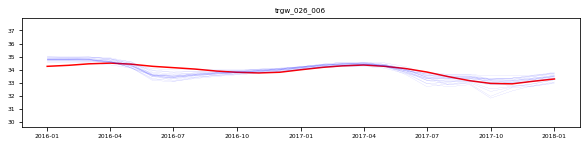

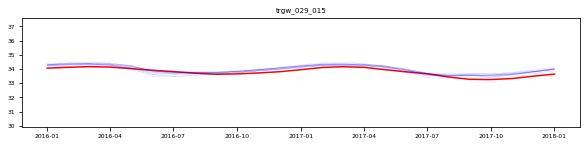

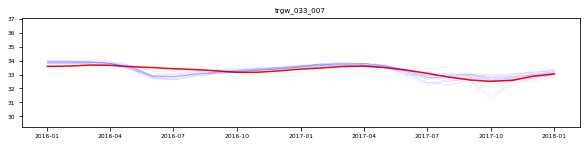

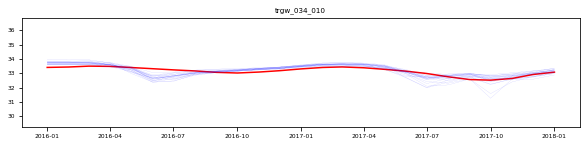

In [15]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))

for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    [ax.plot(nz_obs_group.datetime,oe_pt.loc[r,nz_obs_group.obsnme],color="b",lw=0.1,alpha=0.5) for r in oe_pt.index]
    #mn = oe_base.loc[:,nz_obs_group.obsnme].min()
    #mx = oe_base.loc[:,nz_obs_group.obsnme].max()
    
    #ax.fill_between(nz_obs_group.datetime,mn,mx,fc="r",alpha=0.15)
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
    vmin = nz_obs_group.obsval.min() * 0.9
    vmax = nz_obs_group.obsval.max() * 1.1
    ax.set_ylim(vmin,vmax)
plt.show()

That is really good fit but just about any measure.  But how can the forecasts be wrong if the fit to the historic observations is so good?  